# Standardize ASCAD database

In [1]:
import os

import numpy as np
import seaborn as sns
from matplotlib.pyplot import show
from numpy import logical_and as _and
from numpy.random import shuffle, normal, binomial

from src.data.loaders.ascad import ASCADData
from src.pollution.clock_jitter import clock_jitter
from src.pollution.random_delay import random_delay
from src.tools.cache import cache_np
from src.tools.plotter import init_plots
from src.trace_set.database import Database
from src.trace_set.pollution import Pollution, PollutionType
from src.trace_set.set_hw import TraceSetHW
from src.trace_set.window import extract_traces, get_windows
from src.tvla.tvla import Group

init_plots()

In [16]:
RAW_DATA = ASCADData.raw()
RAW_TRACES, RAW_LABELS = RAW_DATA['traces'], RAW_DATA['hamming_weights']

SAMPLE_TRACE = ASCADData.random_key()['Profiling_traces/traces'][0]

plaintext_ix = 0
full_key_ix = 1

RAW_META = np.array(RAW_DATA["metadata"])[:-1]

def accumulator(metadata):
    return np.zeros((len(metadata), 16), dtype=np.uint8)

def parse_meta(metadata):
    plain = accumulator(metadata)
    key = accumulator(metadata)

    for ix, e in enumerate(metadata):
        plain[ix], key[ix], _ = e

    return plain, key

PLAIN, KEY = parse_meta(RAW_META)

print(PLAIN[:, 0][:10])

FULL_STATES = cache_np("full_states_ascad", full_states, (PLAIN, KEY))

In [17]:
FULL_STATES = cache_np("full_states_ascad")

In [4]:
LABEL_NONE = FULL_STATES[:, 0, 0]
LABEL_MASK = FULL_STATES[:, 0, 2]

Y = np.array(LABEL_MASK)

In [18]:
WINDOW, WINDOW_CXT = get_windows(RAW_TRACES, SAMPLE_TRACE)

WINDOW_CXT

array([79545, 83745])

In [19]:

X_CXT_1 = extract_traces(RAW_TRACES, WINDOW_CXT)

100%|██████████| 300001/300001 [07:19<00:00, 682.00it/s]


### Remove redundant trace from profiling set

In [20]:
X_CXT = X_CXT_1[:-1]

In [21]:
X = X_CXT[:, WINDOW[0]:WINDOW[1]]

In [22]:
def fixed_fixed(x:np.ndarray, hw: np.ndarray):
    leakage_bit = hw > 4
    drop_mask = hw != 4

    return x[drop_mask], leakage_bit[drop_mask]

def tvla_goodwill(x:np.ndarray, la_bits: np.ndarray, order: int):
    ix_shuffle = np.arange(len(x))
    shuffle(ix_shuffle)

    xs, ys = x[ix_shuffle], la_bits[ix_shuffle]

    num_traces = len(x)
    mask = np.zeros(num_traces)
    mask[:round(num_traces / 2)] = 1
    mask = mask.astype(bool)

    low1, low2 = xs[_and(mask, ~ys)], xs[_and(~mask, ~ys)]
    high1, high2 = xs[_and(mask, ys)], xs[_and(~mask, ys)]

    t1, p1 = Group(low1, order, True).t_test(Group(high1, order, True), order)
    t2, p2 = Group(low2, order, True).t_test(Group(high2, order, True), order)

    t = np.min((np.abs(t1), np.abs(t2)), axis=0)
    p = np.max((p1, p2), axis=0)

    return t, p

Computing Central Moments: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


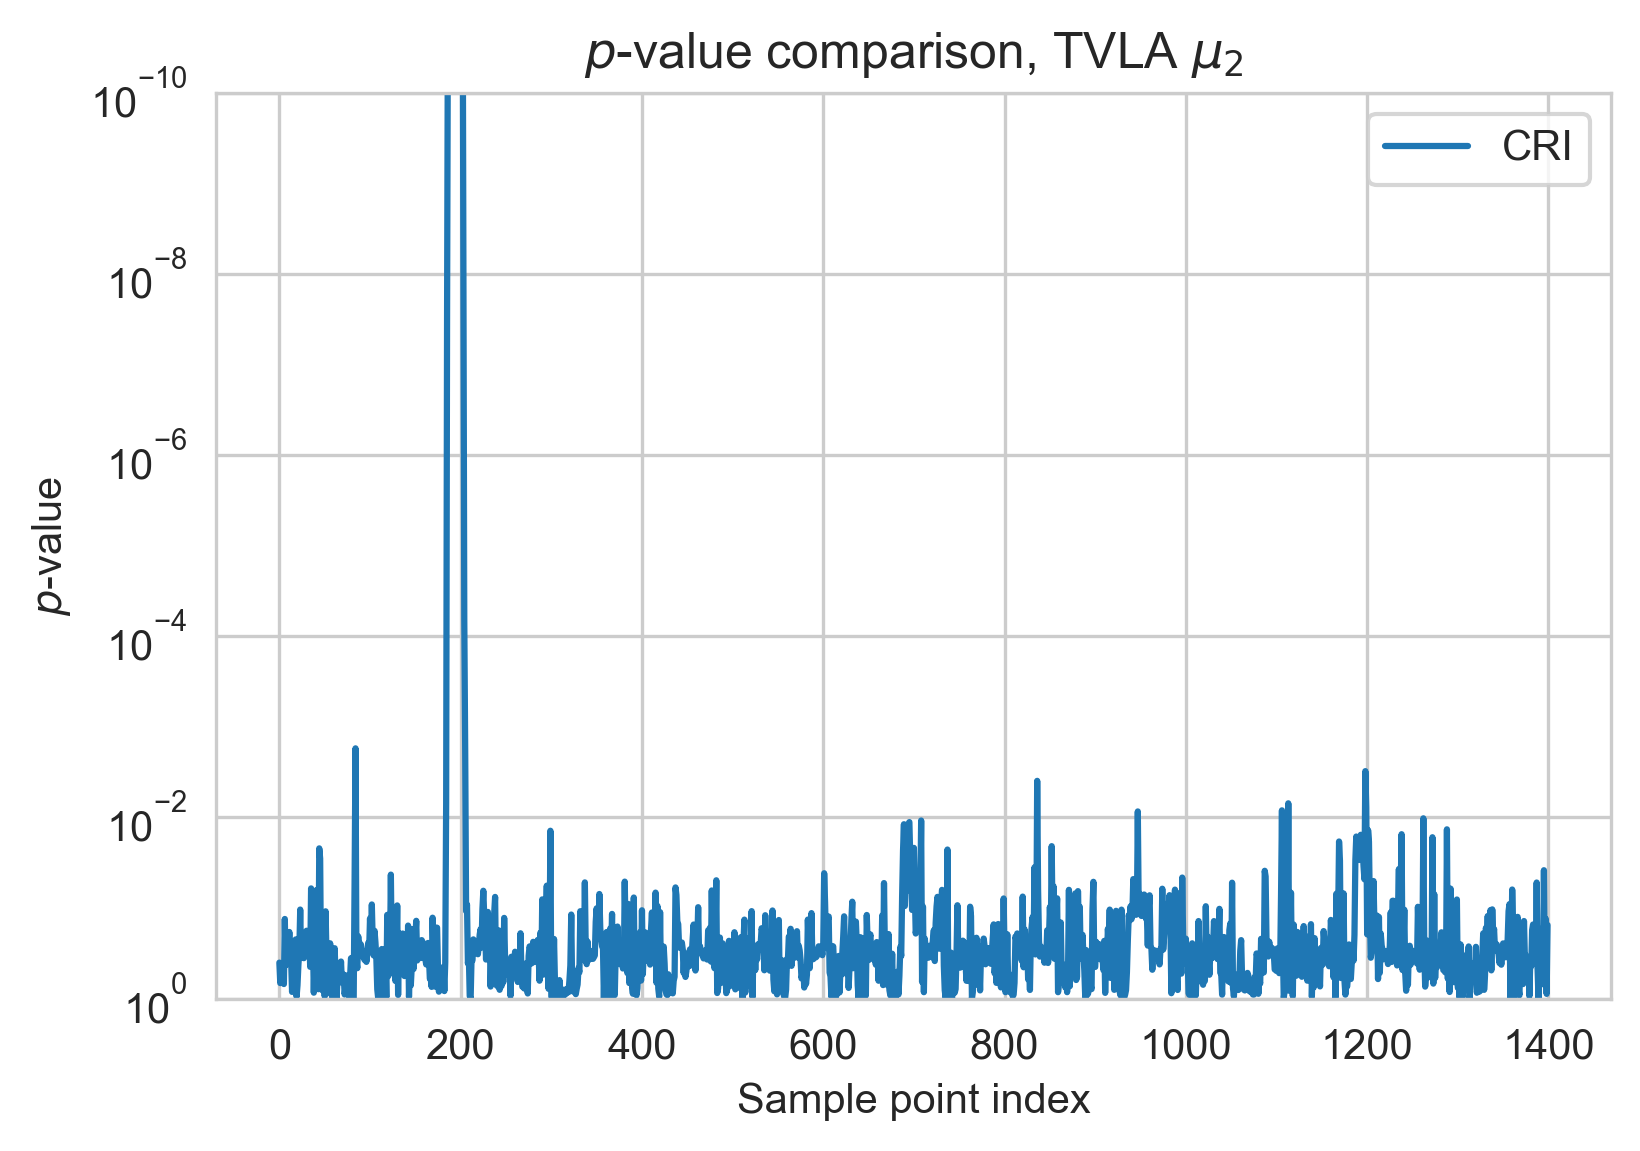

In [23]:
Y_EX = np.array(FULL_STATES[:, 0, 2])

X2, Y2 = fixed_fixed(X, Y)
A, B = X2[~Y2], X2[Y2]
ORDER = 2

_, TVLA_P = Group(A, ORDER, True).t_test(Group(B, ORDER, True), ORDER)
# _, GOODWILL_P = tvla_goodwill(X2, Y2, ORDER)

def plot_p(p_values):
    g = sns.lineplot(data={"CRI": p_values})
    g.invert_yaxis()
    g.set(yscale="log",
          title=f"$p$-value comparison, TVLA $\mu_{ORDER}$",
          xlabel="Sample point index",
          ylabel="$p$-value", ylim=(1, 10**-10))
    show(block=False)

plot_p(TVLA_P)
# plot_p(GOODWILL_P)

In [11]:
PROFILING_MASK = np.ones(len(Y), dtype=bool)
PROFILING_MASK[2::3] = 0

Y_PROF = Y[PROFILING_MASK]
Y_ATT = Y[~PROFILING_MASK]

X_PROF_CXT = X_CXT[PROFILING_MASK]
X_ATT_CXT = X_CXT[~PROFILING_MASK]

X_PROF_CXT.shape, Y_PROF.shape

((200000, 3000), (200000,))

In [12]:
X_PROF = X_PROF_CXT[:, WINDOW[0]:WINDOW[1]]
X_ATT = X_ATT_CXT[:, WINDOW[0]:WINDOW[1]]

TraceSetHW(Database.ascad).create(
    X_PROF, Y_PROF, X_ATT, Y_ATT
)


In [13]:
SIM_NUM_SP = 100000
SIM_NUM_TRACES = 2000
SIM_LABELS = binomial(1, .5, SIM_NUM_SP).astype(np.int8)
SIM_TRACES = normal(0, 2.2, (SIM_NUM_TRACES, SIM_NUM_SP)).astype(np.int8)
A, B = SIM_TRACES[~SIM_LABELS], SIM_TRACES[SIM_LABELS]

In [14]:
_, SIM_TVLA_P = Group(A, 2, True).t_test(Group(B, 2, True), 2)
_, SIM_GOODWILL_P = tvla_goodwill(SIM_TRACES, SIM_LABELS, 2)

MemoryError: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64

In [ ]:
JITTER_PARAMS = np.arange(0, 2.25, .125)

for param in JITTER_PARAMS:
    pollution = Pollution(PollutionType.jitter, param)
    out = TraceSetHW(Database.ascad, pollution)

    if not os.path.exists(out.path):
        profile_jitter = clock_jitter(X_PROF_CXT, WINDOW, param)
        attack_jitter = clock_jitter(X_ATT_CXT, WINDOW, param)

        out.create(profile_jitter, Y_PROF, attack_jitter, Y_ATT)

In [ ]:
DELAY_PARAMS = np.arange(0, .75 + .125, .125)
A = 5
B = 3
DELAY_AMP = 10

for param in DELAY_PARAMS:
    pollution = Pollution(PollutionType.delay, param)
    out = TraceSetHW(Database.ascad, pollution)

    if not os.path.exists(out.path):
        profile_jitter = random_delay(X_PROF, A, B, DELAY_AMP, param)
        attack_jitter = random_delay(X_ATT,A, B, DELAY_AMP, param)

        out.create(profile_jitter, Y_PROF, attack_jitter, Y_ATT)